In [21]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

## Basic EDA

In [2]:
profanity = pd.read_csv('profainity.csv')
profanity.groupby('canonical_form_2').count().head()

,text,canonical_form_1,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description
canonical_form_2,,,,,,,,
arse,6,6,0,6,5,0,6,6
ass,46,46,2,46,38,2,46,46
bastard,2,2,0,2,1,0,2,2
bitch,5,5,0,5,3,0,5,5
butt,8,8,0,8,8,0,8,8


In [4]:
profanity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  1598 non-null   object 
 1   canonical_form_1      1598 non-null   object 
 2   canonical_form_2      210 non-null    object 
 3   canonical_form_3      6 non-null      object 
 4   category_1            1598 non-null   object 
 5   category_2            486 non-null    object 
 6   category_3            21 non-null     object 
 7   severity_rating       1598 non-null   float64
 8   severity_description  1598 non-null   object 
dtypes: float64(1), object(8)
memory usage: 112.5+ KB


In [5]:
profanity.describe()

,severity_rating
count,1598.000000
mean,2.028160
std,0.645068
min,1.000000
25%,1.400000
50%,2.000000
75%,2.600000
max,3.000000


In [6]:
profanity.isnull().sum()

text                       0
canonical_form_1           0
canonical_form_2        1388
canonical_form_3        1592
category_1                 0
category_2              1112
category_3              1577
severity_rating            0
severity_description       0
dtype: int64

In [220]:
word_counts = Counter(profanity['canonical_form_1'])
most_common_values = word_counts.most_common(10)

<BarContainer object of 10 artists>

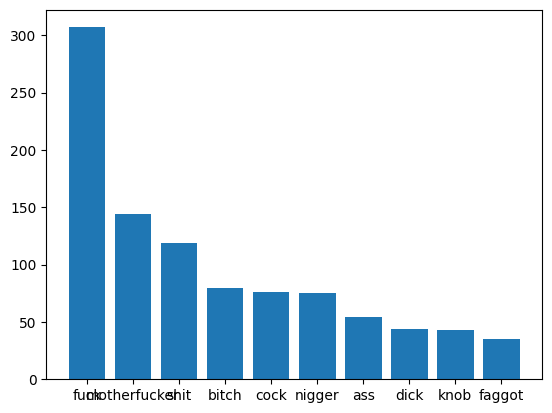

In [221]:
plt.bar(dict(most_common_values).keys(), dict(most_common_values).values())

<AxesSubplot:ylabel='Frequency'>

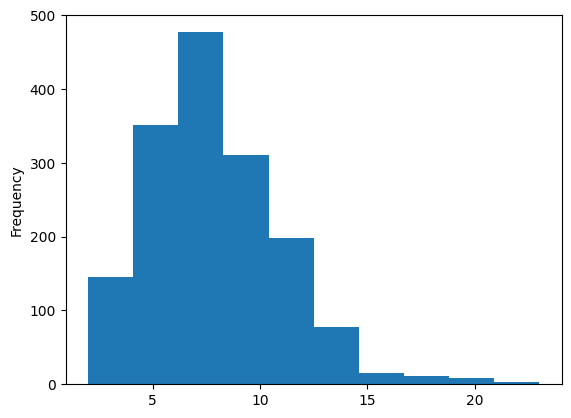

In [8]:
profanity['text_length'] = profanity['text'].apply(lambda x : len(x.replace(' ', '')))
profanity['text_length'].plot(kind = 'hist')

In [9]:
def ends_with_hard_consonant(s):
    hard_consonants = {'b', 'c', 'd', 'g', 'k', 'p', 'q', 't'}
    s = s.rstrip()
    return len(s) > 0 and s[-1].lower() in hard_consonants

profanity['hard_or_not'] = profanity['text'].apply(ends_with_hard_consonant)
profanity.head()


,text,canonical_form_1,canonical_form_2,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description,text_length,hard_or_not
0,69,69,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild,2,False
1,@55,ass,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild,3,False
2,@ssfcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe,8,False
3,@ssfucker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe,9,False
4,@ssfvcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.4,Strong,9,False


<AxesSubplot:xlabel='category_1'>

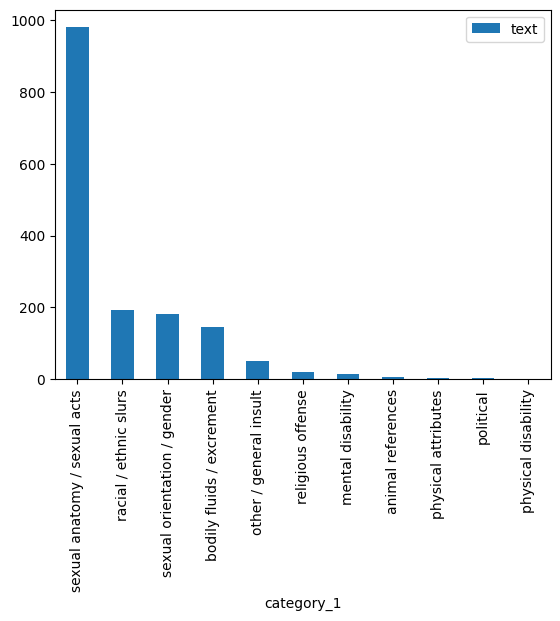

In [10]:
profanity[['category_1', 'text']].groupby('category_1').count().reset_index().sort_values('text', ascending= False).plot(kind = 'bar', x = 'category_1', y= 'text')

In [17]:
profanity['canonical_form_1']

0               69
1              ass
2             fuck
3             fuck
4             fuck
           ...    
1593          wank
1594           wop
1595           wop
1596    zipperhead
1597    zipperhead
Name: canonical_form_1, Length: 1598, dtype: object

In [12]:
pd.Series(profanity['canonical_form_1'].unique()).apply(ends_with_hard_consonant).mean()

0.3319672131147541

In [43]:
#finds the words that compound to other words and check their hard consenants
pd.Series(pd.concat([profanity['canonical_form_1'], profanity['canonical_form_2'], profanity['canonical_form_3']], ignore_index = True).dropna().unique()).apply(ends_with_hard_consonant).mean()

0.3373015873015873

In [30]:
def syllables(arr):
    count = 0
    for i in arr:
        if re.match(r'^[bcdfghjklmnpqrstvwxyz]*[aeiouy]+[bcdfghjklmnpqrstvwxz]*$', i):
            count +=1 
    return count

In [40]:
unique_compound = pd.Series(pd.concat([profanity['canonical_form_1'], profanity['canonical_form_2'], profanity['canonical_form_3']], ignore_index = True).dropna().unique())
unique_compound

0           69
1          ass
2         fuck
3          sex
4       orgasm
        ...   
247        hag
248      nigga
249        pig
250      trash
251    boiolas
Length: 252, dtype: object

In [41]:
monosyllables = unique_compound[unique_compound.apply(syllables) == 1]
monosyllables.apply(ends_with_hard_consonant).mean()

0.65625

<AxesSubplot:xlabel='severity_description'>

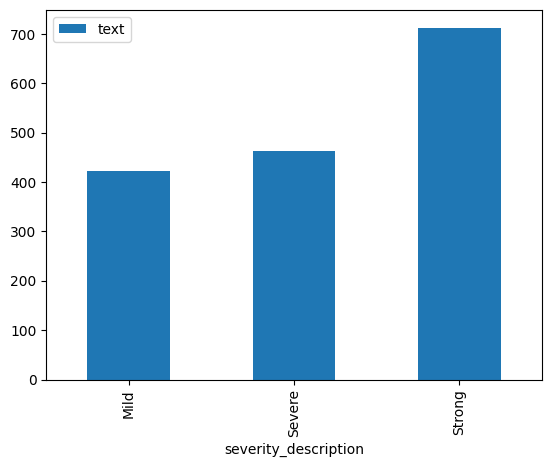

In [42]:
profanity[['severity_description', 'text']].groupby('severity_description').count().reset_index().plot(kind = 'bar', x= 'severity_description' , y = 'text')

### Classifier

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

In [237]:
X = profanity[['text', 'severity_rating', 'hard_or_not']]
y = profanity['category_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2)

In [238]:
def create_ngram_features(words, all_ngrams):
    ngram_features = []
    for word in words:
        ngrams = []
        ngrams.extend([word[idx:idx + n] for n in range(2, 4) for idx in range(len(word) - n + 1)])
        ngram_count = Counter(ngrams)
        feature_vector = [ngram_count.get(ngram, 0) for ngram in all_ngrams]
        ngram_features.append(feature_vector)
    return np.array(ngram_features)

In [239]:
all_ngrams = set()
for word in profanity['text'].to_numpy():
    bigrams = [word[idx:idx + 2] for idx in range(len(word) - 1)]
    trigrams = [word[idx:idx + 3] for idx in range(len(word) - 2)]
    all_ngrams.update(bigrams + trigrams)

In [240]:
X_train_features = np.append(create_ngram_features(X_train['text'], all_ngrams), X_train['severity_rating'].to_numpy().reshape(-1,1), 1)
X_test_features = np.append(create_ngram_features(X_test['text'], all_ngrams), X_test['severity_rating'].to_numpy().reshape(-1,1), 1)

In [241]:
X_train_features = np.append(X_train_features, X_train['hard_or_not'].to_numpy().reshape(-1,1), 1)
X_test_features = np.append(X_test_features, X_test['hard_or_not'].to_numpy().reshape(-1,1), 1)

In [242]:
gnb = GaussianNB()
gnb.fit(X_train_features, y_train)
y_pred = gnb.predict(X_test_features)
(y_pred == y_test).mean()

0.790625

In [243]:
confusion_matrix(y_test, y_pred, labels = profanity['category_1'].unique())

array([[173,   5,   5,   1,   5,   0,   0,   0,   3,   0,   0],
       [ 10,  24,   2,   2,   1,   1,   0,   0,   1,   0,   0],
       [  7,   0,  18,   1,   3,   0,   0,   0,   0,   2,   0],
       [  7,   0,   1,  28,   0,   0,   0,   0,   0,   0,   0],
       [  5,   2,   0,   1,   3,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [244]:
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train_features, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [245]:
log_pred = clf.predict(X_test_features)

In [246]:
clf.score(X_test_features, y_test)

0.76875

In [247]:
confusion_matrix(y_test, log_pred, labels = profanity['category_1'].unique())

array([[192,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 21,  18,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,  14,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 21,   0,   0,  15,   0,   0,   0,   0,   0,   0,   0],
       [  9,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])